In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

df = pd.read_csv("obesity_estimation_modified.csv")
df.head()

Saving obesity_estimation_modified.csv to obesity_estimation_modified.csv


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,mixed_type_col
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,NO,Public_Transportation,Normal_Weight,bad
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,nORMAL_wEIGHT,NaN
2,Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,208
3,Male,27.0,1.8,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,oVERWEIGHT_lEVEL_i,585
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,200


In [3]:

import pandas as pd
import numpy as np
import re
from pathlib import Path

#Ruta del CSV crudo
RAW_PATH = "obesity_estimation_modified.csv"

#Rutas de salida
OUT_DIR = Path("data_outputs")
OUT_DIR.mkdir(exist_ok=True)

CLEAN_PATH = OUT_DIR / "obesity_clean.csv"
ML_READY_PATH = OUT_DIR / "obesity_ml_ready.csv"
LABEL_MAP_PATH = OUT_DIR / "label_map_nobeyesdad.csv"
DATA_DICT_PATH = OUT_DIR / "obesity_data_dictionary.csv"


In [4]:

df_raw = pd.read_csv(RAW_PATH)
print("Shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))
print("\nNulls per column:\n", df_raw.isna().sum().sort_values(ascending=False))
df_raw.head()


Shape: (2153, 18)
Columns: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad', 'mixed_type_col']

Nulls per column:
 mixed_type_col                    241
TUE                                33
CH2O                               29
FAF                                29
Height                             28
Age                                27
NCP                                24
CALC                               23
MTRANS                             23
CAEC                               22
NObeyesdad                         20
family_history_with_overweight     20
SMOKE                              19
Gender                             18
FCVC                               17
FAVC                               16
Weight                             16
SCC                                15
dtype: int64


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,mixed_type_col
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,NO,Public_Transportation,Normal_Weight,bad
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,nORMAL_wEIGHT,NaN
2,Male,23.0,1.8,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,208
3,Male,27.0,1.8,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,oVERWEIGHT_lEVEL_i,585
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,200


In [5]:

def normalize_col(s: str) -> str:
    """snake_case: quita espacios/guiones y minúsculas."""
    s = s.strip()
    s = re.sub(r"\s+", "_", s)      # espacios -> _
    s = s.replace("-", "_")
    s = re.sub(r"_+", "_", s)
    return s.lower()

def clean_cat(val):
    """Limpia categóricos: espacios, guiones, mayúsculas; normaliza yes/no."""
    if pd.isna(val):
        return np.nan
    v = str(val).strip()
    v = re.sub(r"\s+", " ", v)
    v = v.replace("-", "_").replace(" ", "_")
    v = re.sub(r"_+", "_", v).strip("_")
    v_low = v.lower()

    # normalizar yes/no
    if v_low in {"yes","y","si","sí","s"}:
        return "Yes"
    if v_low in {"no","n"}:
        return "No"

    # correcciones comunes del target
    fixes = {
        " nORMAL_wEIGHT ": "Normal_Weight",
        " oVERWEIGHT_lEVEL_i ": "Overweight_Level_I",
        "overweight_level_i_i": "Overweight_Level_II",
        "obesity_type_i_i": "Obesity_Type_II",
        "obesity_type_i_i_i": "Obesity_Type_III",
        "normal_weight": "Normal_Weight",
        "insufficient_weight": "Insufficient_Weight",
    }
    if v in fixes:
        return fixes[v]

    # Title_Case con _
    return "_".join(w.capitalize() for w in v_low.split("_"))


In [6]:

df = df_raw.copy()

# nombres de columnas a snake_case
df.columns = [normalize_col(c) for c in df.columns]

# trim a todas las columnas object y convertir "nan" string a NaN real
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})


In [9]:
#Categricos esperados
cat_cols = [
    "gender",
    "family_history_with_overweight",
    "favc",
    "caec",
    "smoke",
    "scc",
    "calc",
    "mtrans",
    "nobeyesdad",
]
for c in [c for c in cat_cols if c in df.columns]:
    df[c] = df[c].apply(clean_cat)

# Numéricos esperados
num_candidates = ["age","height","weight","fcvc","ncp","ch2o","faf","tue"]
for c in [c for c in num_candidates if c in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [10]:
#nombres en snake_case y tipos
print(df.columns.tolist())
print(df.dtypes)

#categorías limpias
for c in ["gender","family_history_with_overweight","favc","caec","smoke","scc","calc","mtrans","nobeyesdad"]:
    if c in df.columns:
        print(c, sorted(df[c].dropna().unique())[:10])

# Checa cuántos NaN quedan antes de imputar
df.isna().sum().sort_values(ascending=False).head(10)


['gender', 'age', 'height', 'weight', 'family_history_with_overweight', 'favc', 'fcvc', 'ncp', 'caec', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'nobeyesdad', 'mixed_type_col']
gender                             object
age                               float64
height                            float64
weight                            float64
family_history_with_overweight     object
favc                               object
fcvc                              float64
ncp                               float64
caec                               object
smoke                              object
ch2o                              float64
scc                                object
faf                               float64
tue                               float64
calc                               object
mtrans                             object
nobeyesdad                         object
mixed_type_col                     object
dtype: object
gender ['Female', 'Male']
family_histor

,0
mixed_type_col,241
height,42
tue,39
age,34
ncp,34
ch2o,32
faf,31
fcvc,29
weight,26
mtrans,23


In [11]:

if "mixed_type_col" in df.columns:
    coerced = pd.to_numeric(df["mixed_type_col"], errors="coerce")
    na_ratio = coerced.isna().mean()
    if na_ratio <= 0.30:
        # Suficientemente numérica: mantener como número
        df["mixed_type_col_num"] = coerced
        df.drop(columns=["mixed_type_col"], inplace=True)
    else:
        # Tratarla como categórica; si queda muy vacía, eliminar
        df["mixed_type_col"] = df["mixed_type_col"].apply(clean_cat)
        if df["mixed_type_col"].isna().mean() > 0.50:
            df.drop(columns=["mixed_type_col"], inplace=True)


In [12]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_now = df.select_dtypes(include=["object"]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols_now:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")


In [13]:
df.isna().sum().sort_values(ascending=False).head(15)


,0
gender,0
age,0
height,0
weight,0
family_history_with_overweight,0
favc,0
fcvc,0
ncp,0
caec,0
smoke,0


In [14]:
#definimos limites saludables
bounds = {
    "age": (10, 100),
    "height": (0.9, 2.5),   # metros
    "weight": (20, 300),   # kg
}
for col, (lo, hi) in bounds.items():
    if col in df.columns:
        df[col] = df[col].clip(lower=lo, upper=hi)


In [15]:

df.to_csv(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH.resolve())


Saved: /content/data_outputs/obesity_clean.csv


In [16]:
# Dataset listo para ML
target_col = "nobeyesdad" if "nobeyesdad" in df.columns else None

# One-hot para todos los categóricos excepto el target
cat_for_ohe = [c for c in df.select_dtypes(include=["object"]).columns if c != target_col]
ml_df = pd.get_dummies(df, columns=cat_for_ohe, drop_first=True)

# Label encoding del target
if target_col:
    labels = {label: idx for idx, label in enumerate(sorted(df[target_col].unique()))}
    ml_df["target_nobeyesdad"] = df[target_col].map(labels)
    pd.DataFrame(list(labels.items()), columns=["label","id"]).sort_values("id").to_csv(LABEL_MAP_PATH, index=False)
    print("Saved:", LABEL_MAP_PATH.resolve())

ml_df.to_csv(ML_READY_PATH, index=False)
print("Saved:", ML_READY_PATH.resolve())


Saved: /content/data_outputs/label_map_nobeyesdad.csv
Saved: /content/data_outputs/obesity_ml_ready.csv


In [17]:
# --- Generar Diccionario de Datos ---
data_dict = pd.DataFrame({
    "Column": df.columns,
    "DataType": df.dtypes.astype(str),
    "Description": [
        "Sexo de la persona (Male/Female)" if c == "gender" else
        "Edad en años" if c == "age" else
        "Altura en metros" if c == "height" else
        "Peso en kilogramos" if c == "weight" else
        "Historial familiar de sobrepeso" if c == "family_history_with_overweight" else
        "Consumo frecuente de comida rápida" if c == "favc" else
        "Consumo de vegetales" if c == "fcvc" else
        "Número de comidas principales" if c == "ncp" else
        "Consumo de snacks entre comidas" if c == "caec" else
        "Hábito de fumar" if c == "smoke" else
        "Consumo de agua (litros/día)" if c == "ch2o" else
        "Monitorización de calorías diarias" if c == "scc" else
        "Actividad física semanal (horas)" if c == "faf" else
        "Tiempo frente a pantallas (horas/día)" if c == "tue" else
        "Consumo de alcohol" if c == "calc" else
        "Medio de transporte principal" if c == "mtrans" else
        "Nivel de obesidad (target)" if c == "nobeyesdad" else
        "Variable generada en la etapa de codificación / features dummy"
        for c in df.columns
    ]
})

# Guardar
data_dict.to_csv("data_outputs/obesity_data_dictionary.csv", index=False)
print("Diccionario de datos generado y guardado.")


Diccionario de datos generado y guardado.


In [18]:
#
from sklearn.model_selection import train_test_split

if "target_nobeyesdad" in ml_df.columns:
    X = ml_df.drop(columns=["target_nobeyesdad"])
    y = ml_df["target_nobeyesdad"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train.to_csv(OUT_DIR/"X_train.csv", index=False)
    X_test.to_csv(OUT_DIR/"X_test.csv", index=False)
    y_train.to_csv(OUT_DIR/"y_train.csv", index=False)
    y_test.to_csv(OUT_DIR/"y_test.csv", index=False)
    print("Saved train/test split in:", OUT_DIR.resolve())


Saved train/test split in: /content/data_outputs


In [20]:
print(ml_df.shape)

(2153, 810)


In [21]:
print(ml_df.dtypes.head(15))

age                                       float64
height                                    float64
weight                                    float64
fcvc                                      float64
ncp                                       float64
ch2o                                      float64
faf                                       float64
tue                                       float64
nobeyesdad                                 object
gender_Male                                  bool
gender_Unknown                               bool
family_history_with_overweight_No            bool
family_history_with_overweight_Unknown       bool
family_history_with_overweight_Yes           bool
favc_Unknown                                 bool
dtype: object


In [22]:
print(ml_df.isna().sum().sum())  # debería dar 0

0


In [23]:
ml_df.head()

,age,height,weight,fcvc,ncp,ch2o,faf,tue,nobeyesdad,gender_Male,...,mixed_type_col_990,mixed_type_col_991,mixed_type_col_994,mixed_type_col_995,mixed_type_col_996,mixed_type_col_997,mixed_type_col_998,mixed_type_col_Bad,mixed_type_col_Unknown,target_nobeyesdad
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,Normal_Weight,False,...,False,False,False,False,False,False,False,True,False,2
1,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0,Normal_Weight,False,...,False,False,False,False,False,False,False,False,True,2
2,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0,Normal_Weight,True,...,False,False,False,False,False,False,False,False,False,2
3,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0,Overweight_Level_I,True,...,False,False,False,False,False,False,False,False,False,6
4,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0,Overweight_Level_Ii,True,...,False,False,False,False,False,False,False,False,False,7


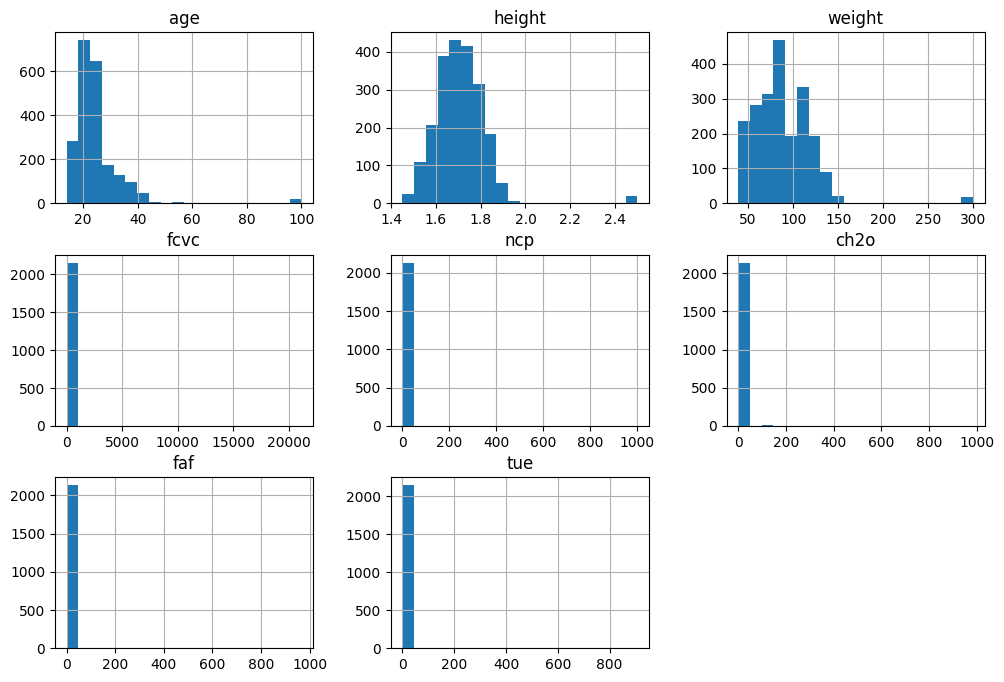

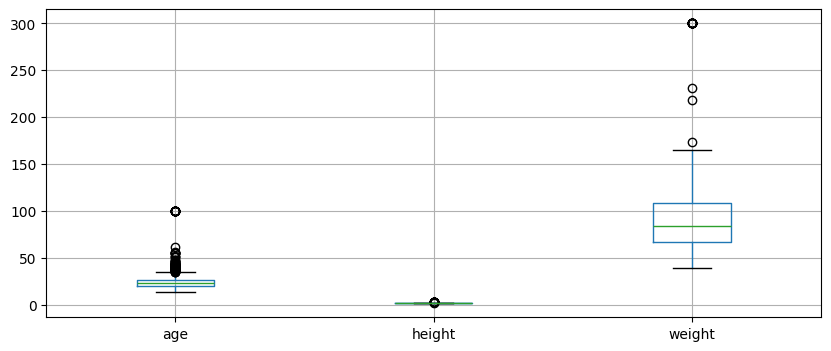

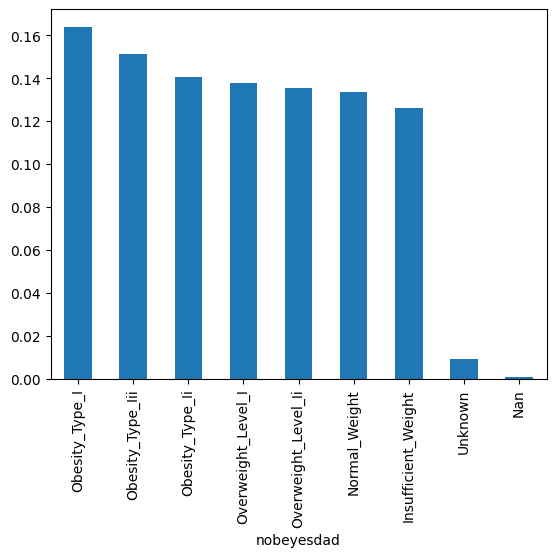

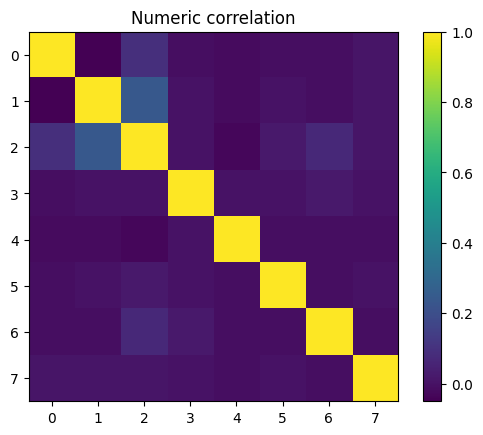

In [24]:
import matplotlib.pyplot as plt
df.describe().T  # tabla
df[['age','height','weight','fcvc','ncp','ch2o','faf','tue']].hist(bins=20, figsize=(12,8)); plt.show()
df.boxplot(column=['age','height','weight'], figsize=(10,4)); plt.show()
df['nobeyesdad'].value_counts(normalize=True).plot(kind='bar'); plt.show()
corr = df.select_dtypes('number').corr().round(2)
plt.imshow(corr, cmap='viridis'); plt.colorbar(); plt.title('Numeric correlation'); plt.show()


In [25]:
from google.colab import files

# Descargar cada archivo
files.download("data_outputs/obesity_clean.csv")
files.download("data_outputs/obesity_ml_ready.csv")
files.download("data_outputs/label_map_nobeyesdad.csv")
files.download("data_outputs/obesity_data_dictionary.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>